In [1]:
# Colin Crowe 5/8/2022

import random
import utils
import numpy as np
import matplotlib.pyplot as plt

By now, I've explained what Chargaff's Second Parity Rule is, and introduced you to this graph that I'll be referencing as we go. If you don't know what this means, check out the "problem" file first before jumping in here.

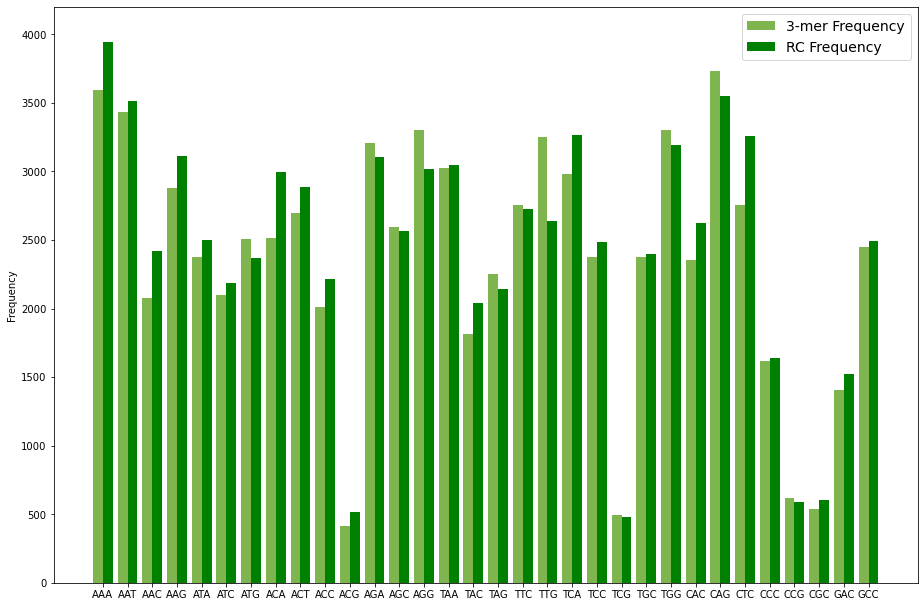

In [2]:
BRCA1 = utils.dump_graph()

Here's an idea - we know from the first parity rule that A's are always across from T's, and C's are always across from G's. Let's say we have some piece of DNA where one strand has a lot of A's and not a lot of T's. If some section of the DNA swapped places with the other strand, then that would replace the excess A's with T's, causing the single-strand to follow the second parity rule.

As it turns out, something like this does happen during replication. An "inversion" is when a section of the top and bottom strands get reversed and switch places with each other. If this happened frequently enough, could this account for the parity rule?

To investigate, I picked a 3-mer that had a large discrepancy between the frequency of itself and its reverse complement. Upon inspection in the graph above, CTC fit the bill pretty well, so this is what I used to test this inversion theory. 

The idea is this: count how many times CTC and its reverse compliment, GAG, appear in the genome. Then, perform 1000 inversions of random 10-character sequences in the genome, and re-count the number of occurances of CTC and GAG appear. Do this a bunch of times, and see if doing a bunch of inversions brings us closer to meeting the second parity rule.

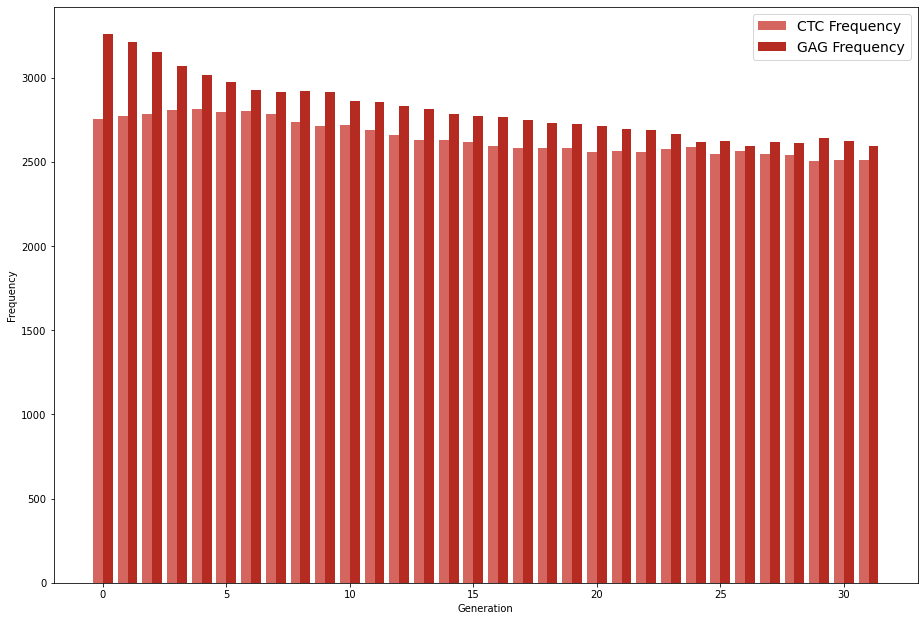

In [17]:
inversion = BRCA1
CTC = 'CTC'
tmer_count, rc_count = [0], [0]
tmer_count[0], rc_count[0] = utils.get_kmer_rc_count(inversion, CTC)
for i in range(31):
    inversion = utils.random_inversion(inversion, 1000, 10)
    one, two = utils.get_kmer_rc_count(inversion, CTC)
    tmer_count.append(one)
    rc_count.append(two)
    
data = [tmer_count, rc_count]
X = np.arange(32)
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(X - 0.2, data[0], color = '#d4665f', width = 0.4)
ax.bar(X + 0.2, data[1], color = '#b52a21', width = 0.4)
ax.set_ylabel('Frequency')
ax.set_xlabel('Generation')
plt.legend(['CTC Frequency', 'GAG Frequency'],loc=1,prop={'size': 14})

As you can see in the above graph, it seemed to work! Here, each "generation" means 1000 random inversions, and doing them brought the two counts closer together.

But, there's also this subtle downard trend. Why is that? To investigate further, I took one of the sequences that occured the least frequently, TCG, and applied this process to it, too:

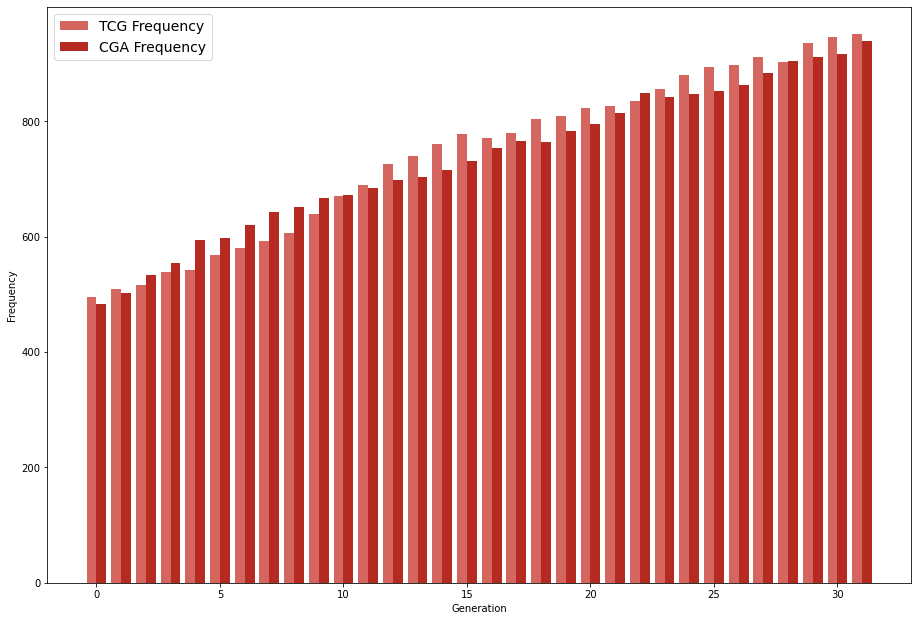

In [19]:
inversion = BRCA1
TCG = 'TCG'
tmer_count, rc_count = [0], [0]
tmer_count[0], rc_count[0] = utils.get_kmer_rc_count(inversion, TCG)
for i in range(31):
    inversion = utils.random_inversion(inversion, 1000, 10)
    one, two = utils.get_kmer_rc_count(inversion, TCG)
    tmer_count.append(one)
    rc_count.append(two)
    
data = [tmer_count, rc_count]
X = np.arange(32)
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(X - 0.2, data[0], color = '#d4665f', width = 0.4)
ax.bar(X + 0.2, data[1], color = '#b52a21', width = 0.4)
ax.set_ylabel('Frequency')
ax.set_xlabel('Generation')
plt.legend(['TCG Frequency', 'CGA Frequency'],loc=2,prop={'size': 14})

And we see a clear upward trend. Strange!

It turns out that doing this random inversion process pulled most our k-mer counts toward the center. Here's a comparison, with the original distribution in green and the new one in red:

(0.0, 4200.0)

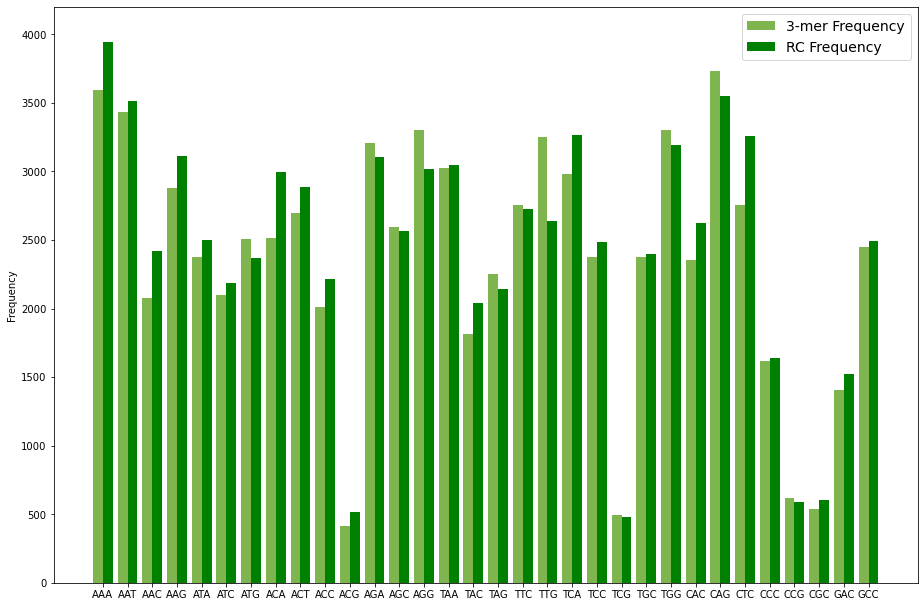

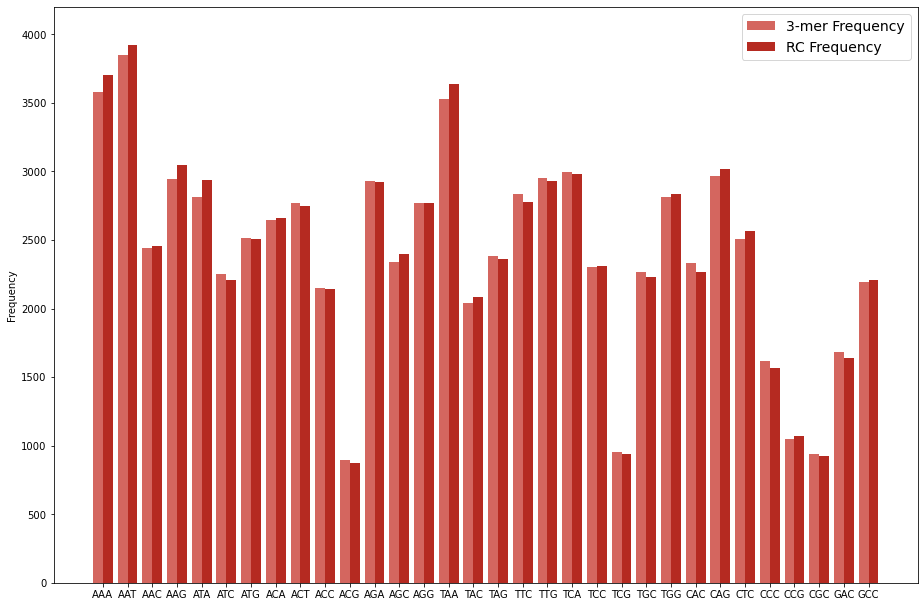

In [24]:
utils.dump_graph()

three_mers = utils.get_3mers()
tmer_count, rc_count = utils.count_kmers(inversion, three_mers)
empty = []
for i in range(32):
    empty.append(0)
data = [tmer_count, rc_count]
X = np.arange(32)
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(X - 0.2, data[0], color = '#d4665f', width = 0.4)
ax.bar(X + 0.2, data[1], color = '#b52a21', width = 0.4)
ax.bar(three_mers, empty)
ax.set_ylabel('Frequency')
plt.legend(['3-mer Frequency', 'RC Frequency'],loc=1,prop={'size': 14})
plt.ylim([0, 4200])

Notably this comparison allows us to see that doing these inversions did bring everything closer to perfectly satisfying the second parity rule, but the fact that it also pulled everything towards a uniform distribution makes me skeptical that this is what's actually going on. If lots and lots of inversions were happening during DNA replication, why is there still so much disparity in frequencies? Shouldn't those have gotten reduced?

So, I'm not a believer in inversions, but that doesn't mean other researchers haven't had success trying to model the second parity rule using this concept. Rather than simulate the effects of repeated inversions like I did, Kohji Okamura, John Wei, and Stephen W. Scherer used mathematical equations to determine if doing inversions would lead to satisfying the parity rule. The rest of this document will be a brief summary of what they found, but I would encourage you to read the paper for yourself for more information.

They defined two variables, $A_n$ and $T_n$, that represented the frequency of any sequence and its reverse compliment after $n$ inversions, respectively. They also defined $r_n$ to be the length of the $n$th inversion, relative to the length of the entire genome. With these variables, they defined the following equations:

$A_n = A_{n-1} - r_n(A_{n-1} - T_{n-1})$

$T_n = T_{n-1} - r_n(T_{n-1} - A_{n-1})$

How these equations were derived should be pretty self-explanatory. The frequency of some sequence after an inversion is equal to the frequency of that sequence before that inversion plus some other factor that represents the change in frequency caused by the inversion.

Something to note about these equations is that they trend towards each other as n increases. If $A_{n - 1}$ is much larger than $T_{n - 1}$, then the $(A_{n-1} - T_{n-1})$ term will be positive, meaning that $A_n$ will get smaller since we subtract that term from it. Similarly, $(T_{n-1} - A_{n-1})$ would be negative, so $T_n$ would get larger. This would suggest that, as $n$ increases without bound, $A_n$ will equal $T_n$. This is exactly what the researchers concluded, albeit through far more rigorous means than me:

$lim_{n \to \infty} A_n = lim_{n \to \infty} T_n = \frac{A_0 + T_0}{2}$

This allows us to see that, if a lot of inversions take place, $A_\infty = T_\infty$. Since $A$ represents the frequency of a sequence and $T$ represents the frequency of that sequence's reverse complement, if they trend towards being equal, then frequent inversions would account for the second parity rule.

Here's the citation for that paper:

Okamura K, Wei J, Sherer SW. Evolutionary implications of inversions that have caused intra-strand parity in DNA. BMC Genomics 2007;8:160.

And here's a link if you want to read it for yourself:

https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-8-160